# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

Отправлять дз не нужно, нужно закоммитить в github. Сдается дз лично преподавателю на рубежном контроле (13 марта)

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма EM

Cчитываем данные, полученные в результате выполнения домашнего задания из курса введения, в `data frame` библиотеки `pandas`. Достаем координаты и конвертируем в массив `numpy`. Возможно, в собранном вами файле кодировка будет иной.

In [2]:
data_df = pd.read_csv("dataset.csv", sep=",", header=0)
data_df.head()
data_df.fillna(data_df.mean())

,Num,Address,Checkins,City,Country,Created,Latitude,Longitude,Title,Type
0,1,Мячковский б-р 3а,435,1,1,1280741941,55.657941,37.751574,Baila Baila,4
1,2,Дачная 2а,14,123,1,1280741941,53.202017,50.141377,Lust,4
2,3,Лени Голикова 29,8,2,1,1280741941,59.843376,30.231480,Тайфун,4
3,4,Героев Танкограда 63,8,158,1,1280741941,55.174954,61.451611,Hollywood,4
4,5,Мусы Джалиля 14К1,38,99,1,1280741941,54.860834,83.091932,Барабас,4
5,6,Мусы Джалиля 14,6,99,1,1280741941,54.861114,83.091415,Опера,4
6,7,Труда 153,15,158,1,1280741941,55.166948,61.395017,Малахит,4
7,8,Сони Кривой 81,3,158,1,1280741941,55.157006,61.365395,Полет,4
8,9,просп. Ленина 66а,161,158,1,1280741941,55.160365,61.380302,Уральские пельмени,4
9,10,Гурьянова 31,13,1,1,1280741941,55.684858,37.718300,Salvador Dali,4


In [3]:
x = data_df[['Latitude', 'Longitude']].values
print x

[[ 55.657941  37.751574]
 [ 53.202017  50.141377]
 [ 59.843376  30.23148 ]
 ..., 
 [ 55.76363   37.597046]
 [ 56.002732  37.209755]
 [ 47.225695  39.72997 ]]


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

1 Баранчиков Максим	
2 Бекбулатов Рамзан	
3 Белозёров Михаил	
4 Бобылев Владислав	
5 Брызгалов Антон	
6 Будюк Алексей	
7 Валиуллин Альберт	
8 Валиуллин Артур	
9 Васильев Евгений	
10 Галицкий Игорь	
11 Горшков Сергей	
12 Гусев Вячеслав	
13 Дегтярев Роман	
14 Дементьев Максим	
15 Елохов Артур	
16 Ефимов Владислав	
17 Зайцев Александр	
18 Ильин Иван	
19 Имеев Мерген	
20 Камалбеков Тимур	
21 Капитонов Александр	
22 Каспарьянц Георгий	
23 Кафанов Олег	
24 Клейменов Андрей	
25 Козлов Иван	
26 Колмакова Татьяна	
27 Комов Евгений	
28 Крылов Иван	
29 Кузьмина Ирина	
30 Куклева Анна	
31 Курьянов Илья	
32 Лобанов Алексей	
33 Лозинский Иван	
34 Лузин Игорь	
35 Лукьянчиков Иван	
36 Неред Максим	
37 Новикова Анастасия	
38 Новичков Сергей	
39 Омаров Темирхан	
40 Павлова Анастасия	
41 Петренко Иван	
42 Пилюгин Вадим	
43 Плошкин Александр	
44 Полякова Вера	
45 Попкова Екатерина	
46 Преображенский Анатолий	
47 Пронин Сергей	
48 Пучкин Данила	
49 Рогачев Александр	
50 Руденко Дмитрий	
51 Рыбаков Владислав	
52 Санников Артём	
53 Скиба Глеб	
54 Страдомский Сергей	
55 Тескер Константин	
56 Трифанов Петр	
57 Хапкин Артем	
58 Хорошенький Илья	
59 Чокля Дмитрий	
60 Шмурак Денис	
61 Щербакова Елена	

In [4]:
N = 52 # put your index here

In [5]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [219]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans
import math

class Clustering(BaseEstimator, ClusterMixin):
    
    def __init__(self, n_components=1, max_iter=100):
        
        self.n_components=n_components
        self.max_iter=max_iter
        
        
    def fit(self, x, y=None):
        # используем Kmeans для начального приближения 
        model = KMeans(n_clusters=self.n_components)
        model.fit(x)
        y = model.predict(x)
        # Первая апроксимация
        self.pi = np.array([float(list(y).count(cl_id))/len(y) 
                            for cl_id in xrange(self.n_components)])
        self.mu = model.cluster_centers_
        self.sigma = [[line*np.random.rand() for line in np.identity(len(x[0]))] 
                      for i in xrange(self.n_components)]
        
        old_y = None
        
        iteration = 0
        
        def stop_cretaria(y, old_y):
            delta = max([np.sqrt(np.sum((v) ** 2)) for v in y - old_y])
            if delta < 0.0001:
                return True
            else: 
                return False
        
        while(iteration != self.max_iter):
            
            old_y = y
            
            y = self.e_step(x)
            self.m_step(x,y)
            iteration+=1
            
            if iteration > 2:
                if(stop_cretaria(y, old_y)):
                    break
        
        return self
    
    
    def predict(self, x):
        return self
    

    
    def e_step(self, x):
        
        y = np.array([ [vec - mu_i for mu_i in self.mu] for vec in x])
        sigma_det = np.array([np.linalg.det(sigma_i) for sigma_i in self.sigma])
        
        for i in xrange(len(sigma_det)):
            if sigma_det[i] == 0:
                self.sigma[i] = [line*np.random.rand() for line in np.identity(len(self.sigma[i]))]
                sigma_det[i] = np.linalg.det(self.sigma[i])
        
        inv_matrixes = np.array([np.linalg.inv(sigma_i) for sigma_i in self.sigma])
        
        
        y = [[(self.pi[cl_id]/np.sqrt(sigma_det[cl_id]))*
              np.exp((-0.5)*np.dot(np.dot(vec[cl_id],inv_matrixes[cl_id]),vec[cl_id])) 
              for cl_id in xrange(self.n_components)] 
             for vec in y]
        
        #y = [vec/sum(vec) for vec in y]
        def normolize_vec(v):
            if sum(v) == 0.0:
                return (1.0/len(v))*np.ones(len(v))
            else:
                return v/(sum(v))
            
        y = np.array([normolize_vec(v) for v in y])
        
        return y
        
    def m_step(self,x,y):
        N_k = np.array([sum(y[:, cl_id]) for cl_id in xrange(self.n_components)])
        
        self.pi = N_k/len(y)
        self.mu = np.array([ (1.0/N_k[cl_id])*
                            np.sum(np.multiply(x, y[:,cl_id][:, np.newaxis]), axis=0) 
                            for cl_id in xrange(self.n_components)])
        self.sigma = np.array([(1.0/N_k[cl_id])* np.sum([y[i,cl_id]*
             np.multiply(
                 x[i]-self.mu[cl_id],
                 np.reshape(x[i]-self.mu[cl_id],(len(x[i]),1))) 
             for i in xrange(len(x))],
            axis=0) 
                                    for cl_id in xrange(self.n_components)])
        
        return self
    
    def predict(self, x):
        y = self.e_step(x)
        return [list(a).index(max(a)) for a in y]
    
    def fit_predict(self, x):
        self.fit(x)
        return self.predict(x)
        # в чём проблема - у тебя где-то код неправильно работает, и y - это один и тот же кластер

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

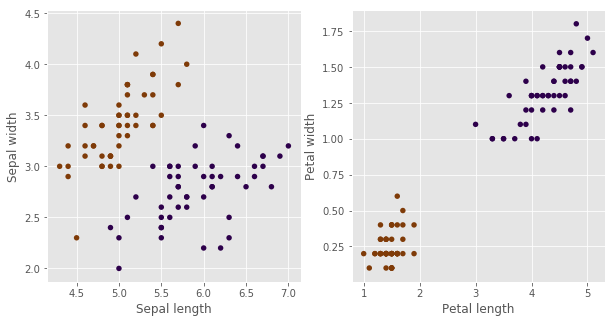

In [190]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [192]:
pred_iris = Clustering(n_components=2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [205]:
from scipy.spatial.distance import cdist
def quality(x, y, centroids):
    """
    Выберем критерий Sihouette, он покажет, 
    что если кластеров слишком мало, то будет наблюдаться большое колличество данных
    принадлежащих какой-либо гауссиане с маленькой вероятностью, что нам и выявит наша метрика.
    С другой стороны, если кластеров будет слишком много, гаусианы будут "наползать" друг на друга,
    и эта метрика выявит, подобные случаи и поможет отыскать "золотую середину".
    """
    
    distances = cdist(x, x)
    cluster_dist = [ [np.average(distances[i][y.index(cl_id)]) 
                      for cl_id in xrange(centroids)] 
                    for i in xrange(len(x))]
    
    def sihoutte_dist(c_dist, own_id):
        min_dist = max(c_dist)
        own_dist = c_dist[own_id]
        for i in xrange(len(c_dist)):
            if (min_dist > c_dist[i]) and (own_id != i):
                min_dist = c_dist[i]
        return (min_dist - own_dist)/max(min_dist,own_dist)
        
    sihoutte = [sihoutte_dist(cluster_dist[i],y[i]) for i in xrange(len(x))]
    return np.average(sihoutte)

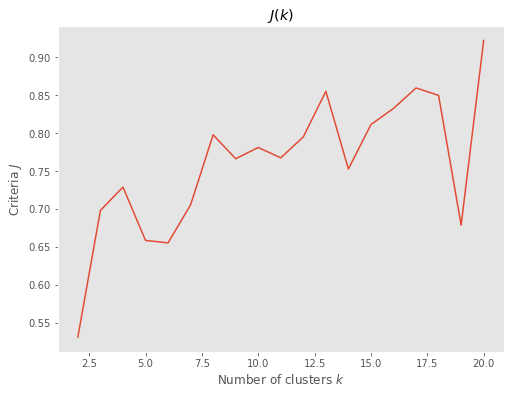

In [220]:
ks = range(2, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(n_components=k)
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y, k)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [38]:
k = 13
cls = Clustering(n_components=k)
y = cls.fit_predict(x)

Визуализируем кластеризацию на карте

/home/artyoms/anaconda3/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/artyoms/anaconda3/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/artyoms/anaconda3/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


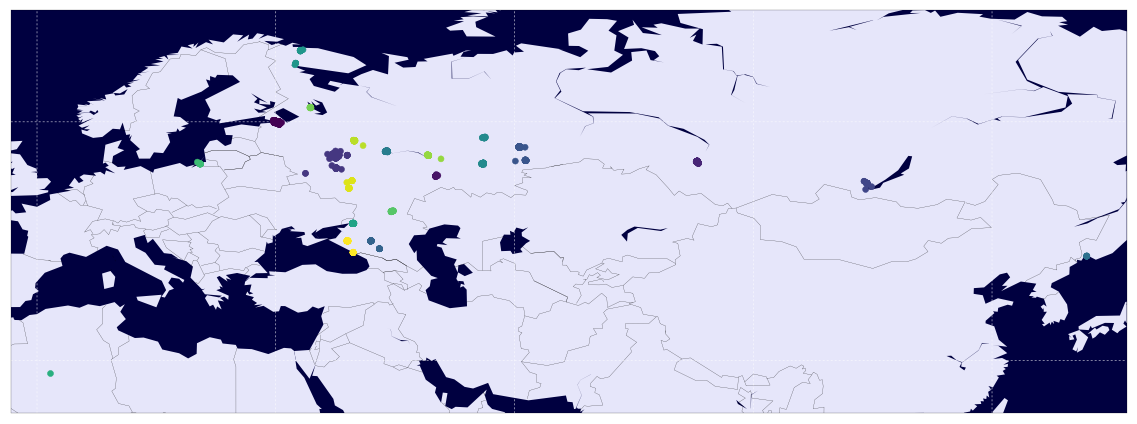

In [221]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x[:, 0]) - 5, urcrnrlat=max(x[:, 0]) + 5, llcrnrlon=min(x[:, 1]) - 5, urcrnrlon=max(x[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

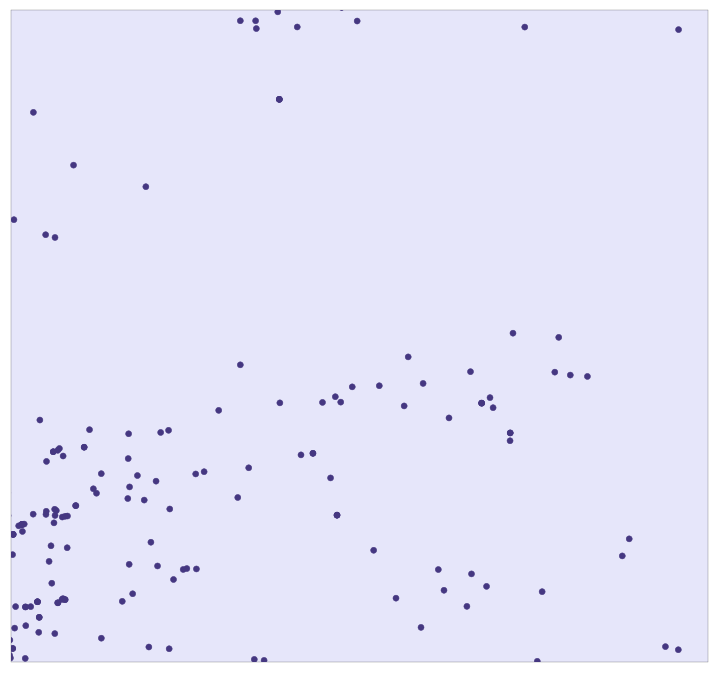

In [237]:
# Moscow
plt.figure(figsize=(20,12))
_CENTER_LAT, _CENTER_LON = 55.7522200, 37.6155600
_LEFT_CORNER_LAT, _LEFT_CORNER_LON =  55.729944, 37.666398
_RIGHT_CORNER_LAT, _RIGHT_CORNER_LON = 55.915872, 37.865182

m = bm.Basemap( projection='cyl', llcrnrlat=_LEFT_CORNER_LAT , urcrnrlat=_RIGHT_CORNER_LAT, llcrnrlon=_LEFT_CORNER_LON , urcrnrlon=_RIGHT_CORNER_LON, resolution='c')
m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

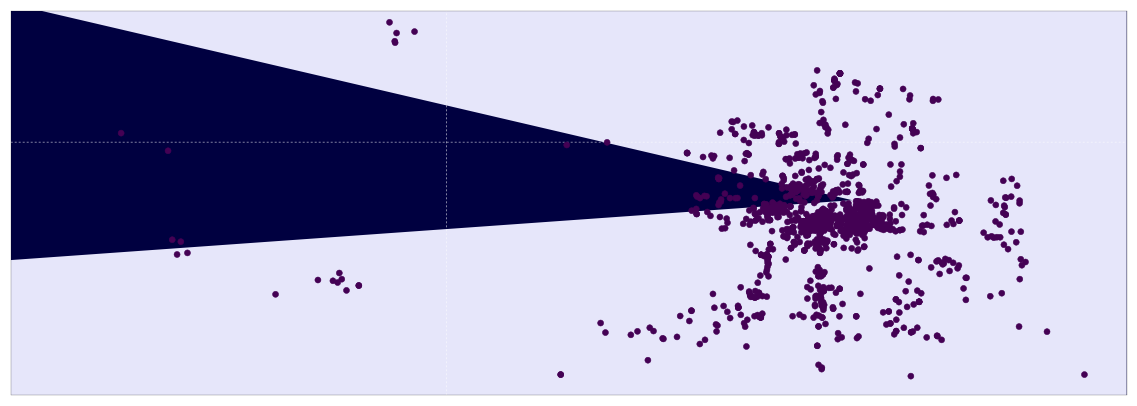

In [236]:
# Sanct-Peterburg
plt.figure(figsize=(20,12))
_LEFT_CORNER_LAT, _LEFT_CORNER_LON =  59.783787, 29.627892
_RIGHT_CORNER_LAT, _RIGHT_CORNER_LON = 60.112382, 30.580956

m = bm.Basemap( projection='cyl', llcrnrlat=_LEFT_CORNER_LAT, urcrnrlat=_RIGHT_CORNER_LAT , llcrnrlon=_LEFT_CORNER_LON , urcrnrlon=_RIGHT_CORNER_LON, resolution='c')
m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Какой вывод можно сделать о качестве кластеризации?
При таком выборе параметра k - результатом кластериза

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.